<a href="https://colab.research.google.com/github/giaminhh041223/Vehicle_detect/blob/main/Vehicle_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


In [3]:
import os
import zipfile
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import random
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
uploaded = files.upload()

Saving archive.zip to archive.zip


In [6]:
zip_filename = next(iter(uploaded))
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

yaml_content = {
    'path': extract_path,
    'train': 'Cars Detection/train/images',
    'val': 'Cars Detection/valid/images',
    'test': 'Cars Detection/test/images',
    'names': {
        0: 'Ambulance',
        1: 'Bus',
        2: 'Car',
        3: 'Motorcycle',
        4: 'Truck'
    }
}

yaml_path = os.path.join(extract_path, 'data_colab.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

model = YOLO("yolo11n.pt")

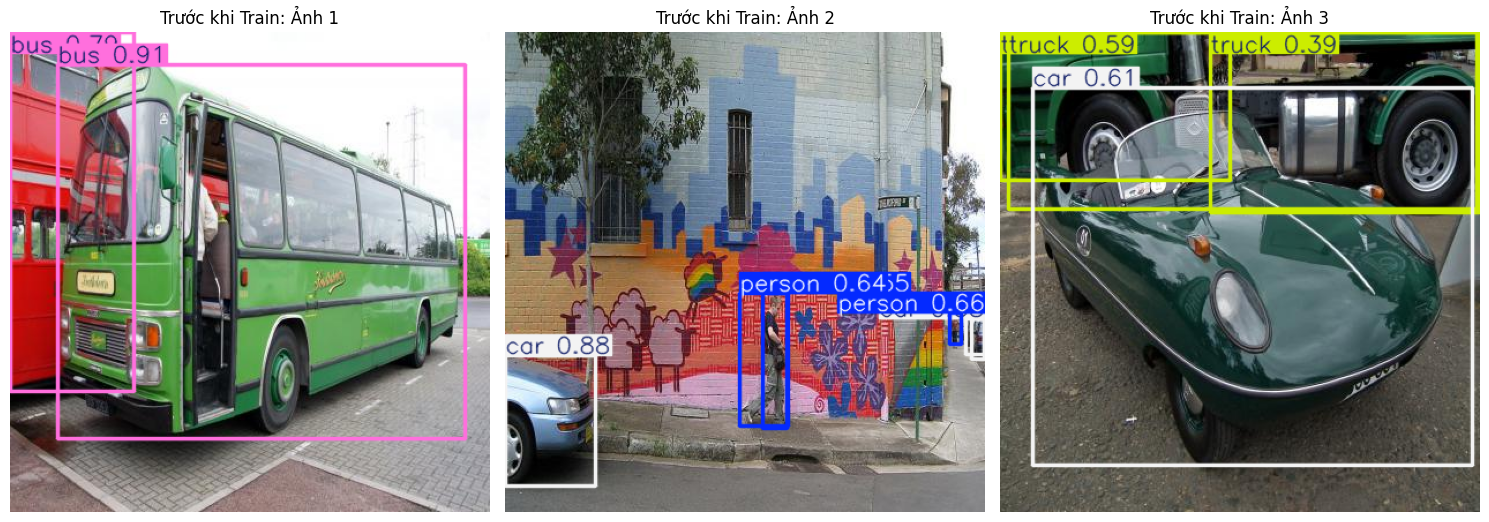

In [5]:
test_path_pre = os.path.join(extract_path, "Cars Detection/test/images")

if os.path.exists(test_path_pre):
    all_imgs = [os.path.join(test_path_pre, f) for f in os.listdir(test_path_pre) if f.endswith(('.jpg', '.png'))]

    sample_imgs = random.sample(all_imgs, min(3, len(all_imgs)))

    results_pre = model.predict(source=sample_imgs, conf=0.25, verbose=False)

    plt.figure(figsize=(15, 6))
    for i, result in enumerate(results_pre):

        img_plot = result.plot()
        img_rgb = cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Trước khi Train: Ảnh {i+1}")

    plt.tight_layout()
    plt.show()

In [1]:

results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    project='/content/runs',
    name='car_detect_run'
)

best_w = os.path.join('/content/runs', 'car_detect_run', 'weights', 'best.pt')
files.download(best_w)

best_model = YOLO(best_w)

test_images_path = os.path.join(extract_path, "Cars Detection/test/images")
predict_results = best_model.predict(source=test_images_path, save=True, project='/content/runs_temp', name='predict')

class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
label_dir = os.path.join(extract_path, "Cars Detection/test/labels")

num_examples = 6
sample_results = random.sample(predict_results, min(num_examples, len(predict_results)))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, result in enumerate(sample_results):
    if i >= num_examples: break

    image_path = result.path
    img = cv2.imread(image_path)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_combined = img.copy()

    label_filename = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    label_path = os.path.join(label_dir, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            for line in file:
                parts = list(map(float, line.split()))
                cls_id = int(parts[0])
                x_center, y_center, width, height = parts[1:]
                h, w, _ = img.shape
                x1, y1 = int((x_center - width/2) * w), int((y_center - height/2) * h)
                x2, y2 = int((x_center + width/2) * w), int((x_center + height/2) * h)

                cv2.rectangle(img_combined, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(img_combined, f"GT: {class_names[cls_id]}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls.item())
        conf = box.conf.item()
        label = class_names[cls_id] if cls_id < len(class_names) else "Unknown"

        cv2.rectangle(img_combined, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_combined, f"{label} {conf:.2f}", (x1, y2 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    axes[i].imshow(img_combined)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path))

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

--- Hãy chọng ảnh bất kỳ để test (jpg, png...) ---


Saving 0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg to 0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg

image 1/1 /content/0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg: 640x640 1 Car, 13.0ms
Speed: 3.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs_temp/predict2


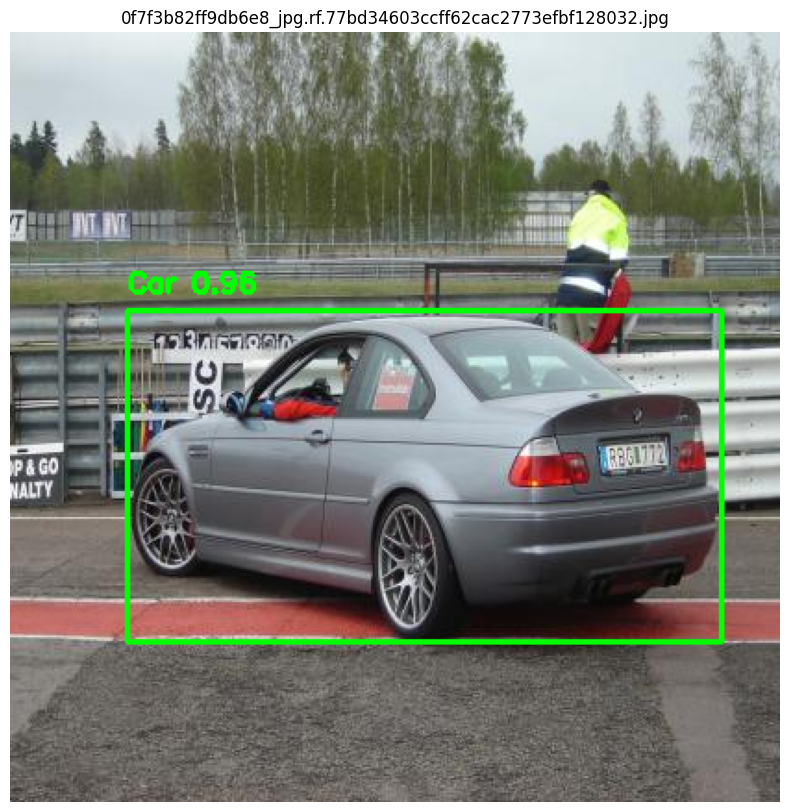

In [ ]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

uploaded = files.upload()
filename = next(iter(uploaded))


results = best_model.predict(source=filename, conf=0.25, save=True)

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls.item())
        conf = box.conf.item()
        label = class_names[cls_id] if cls_id < len(class_names) else "Unknown"

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(f"{filename}")
plt.show()